In [27]:
pip install ultralytics

In [28]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

In [29]:
 #✅ Compute Dark Channel
def dark_channel(image, window_size=35):
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
    return cv2.erode(min_channel, kernel)

In [30]:
# ✅ Estimate Atmospheric Light (A)
def estimate_atmospheric_light(image, dark_channel):
    h, w = image.shape[:2]
    num_pixels = h * w
    num_brightest = int(num_pixels * 0.005)  # Top 0.1% brightest pixels

    # Get indices of brightest pixels in dark channel
    flat_dark = dark_channel.flatten()
    brightest_indices = np.argsort(flat_dark)[-num_brightest:]

    # Compute atmospheric light as the mean of brightest pixels in original image
    A = np.mean(image.reshape(-1, 3)[brightest_indices], axis=0)
    return A

In [31]:
# ✅ Compute Transmission Map
def compute_transmission(image, A, beta=0.985):
    norm_image = image / A  # Normalize by estimated atmospheric light
    dark = dark_channel(norm_image)
    transmission = 1 - beta * dark
    return np.clip(transmission, 0.1, 1.0)  # Prevent complete black regions

In [32]:
# ✅ Manual Guided Filter Implementation
def guided_filter(I, p, radius, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (radius, radius))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (radius, radius))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (radius, radius))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (radius, radius))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (radius, radius))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (radius, radius))

    q = mean_a * I + mean_b
    return q

In [33]:
# ✅ Apply Guided Filter for Transmission Refinement
def refine_transmission(image, transmission, radius=40, eps=1e-4):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.0
    return guided_filter(gray, transmission, radius, eps)

In [34]:

# ✅ Recover Haze-Free Image
def recover_image(image, transmission, A, gamma=0.95):
    J = (image - A) / transmission[:, :, np.newaxis] + A
    J = np.clip(J, 0, 1) ** gamma  # Apply gamma correction
    return (J * 255).astype(np.uint8)

In [35]:
 #✅ Full Non-Local Image Dehazing Function
def non_local_dehazing(image):
    image = image.astype(np.float32) / 255.0  # Normalize image
    dark = dark_channel(image)
    A = estimate_atmospheric_light(image, dark)
    transmission = compute_transmission(image, A)
    transmission_refined = refine_transmission(image, transmission)
    dehazed = recover_image(image, transmission_refined, A)
    return dehazed


In [36]:
# ✅ Load and Dehaze an Image
def load_and_dehaze(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"File not found: {image_path}")

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for display
    dehazed_image = non_local_dehazing(image_rgb)
    return image_rgb, dehazed_image


In [37]:
# ✅ Load YOLOv10 Model
def load_yolo_model(model_path='/content/100epchos best.pt'):
    return YOLO(model_path)

# ✅ Perform Object Detection
def detect_objects(model, image):
    results = model(image, conf=0.35)
    return results


In [38]:
# ✅ Draw YOLOv10 Detections with Larger Labels
def draw_detections(image, results):
    image_with_boxes = image.copy()

    for result in results:
        for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            x1, y1, x2, y2 = map(int, box)
            class_id = int(cls)
            confidence = float(conf)
            label = f"{result.names[class_id]} {confidence:.2f}"

            # Draw bounding box
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 3)
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.rectangle(image_with_boxes, (x1, y1 - h - 5), (x1 + w, y1), (255, 0, 0), -1)
            cv2.putText(image_with_boxes, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return image_with_boxes

In [39]:
# ✅ Display Results
def display_results(original, dehazed, detected):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(dehazed)
    plt.title("Dehazed Image (NLD)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(detected)
    plt.title("Detection Results (YOLOv10)")
    plt.axis("off")

    plt.show()


In [40]:
# ✅ Main Function
def main(image_path='/content/foggimage.png', model_path='/content/100epchos best.pt'):
    # Load and Dehaze Image
    image, dehazed_image = load_and_dehaze(image_path)

    # Load YOLOv10 Model
    model = load_yolo_model(model_path)

    # Detect Objects on Dehazed Image
    results = detect_objects(model, dehazed_image)

    # Draw Detections
    detected_image = draw_detections(dehazed_image, results)

    # Display Results
    display_results(image, dehazed_image, detected_image)


0: 448x640 2 Cars, 669.9ms
Speed: 2.8ms preprocess, 669.9ms inference, 0.2ms postprocess per image at shape (1, 3, 448, 640)


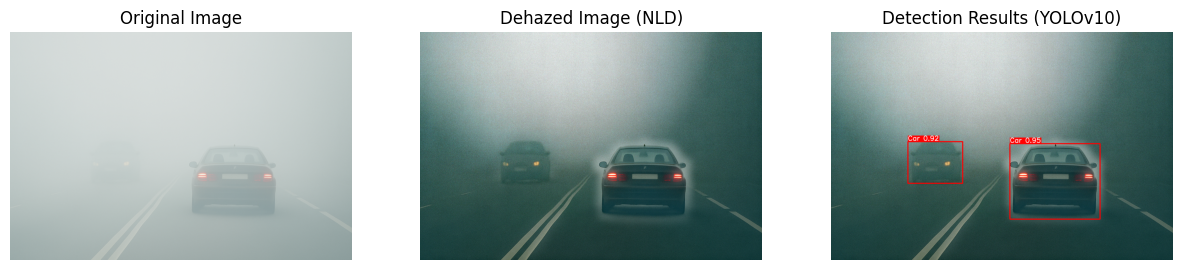

In [41]:
main()

In [47]:
def display_detection_only(detected):
    plt.figure(figsize=(8, 6))
    plt.imshow(detected)
    plt.title("Detection Results (YOLOv10 on Dehazed Image)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [48]:
def main(image_path='/content/foggimage.png', model_path='/content/100epchos best.pt'):
    # Load and Dehaze Image
    _, dehazed_image = load_and_dehaze(image_path)

    # Load YOLOv10 Model
    model = load_yolo_model(model_path)

    # Detect Objects on Dehazed Image
    results = detect_objects(model, dehazed_image)

    # Draw Detections
    detected_image = draw_detections(dehazed_image, results)

    # ✅ Display Only Detection Image
    display_detection_only(detected_image)



0: 448x640 2 Cars, 636.2ms
Speed: 3.0ms preprocess, 636.2ms inference, 0.3ms postprocess per image at shape (1, 3, 448, 640)


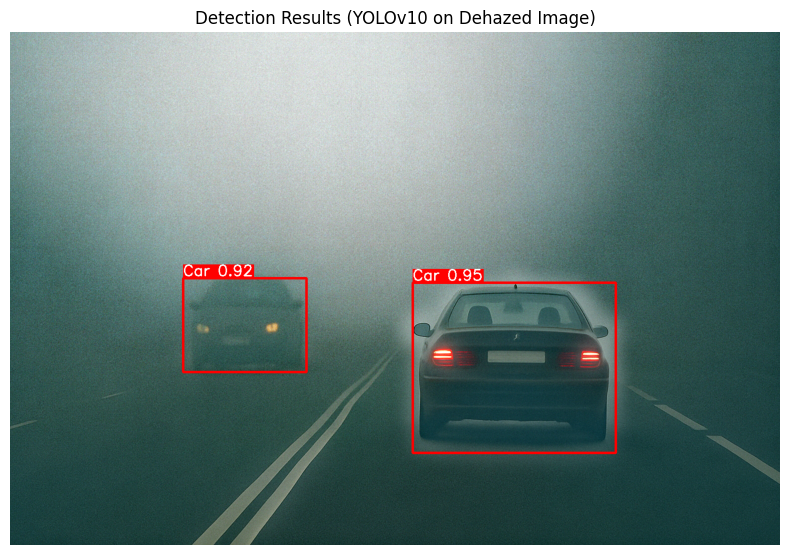

In [49]:
main()


In [19]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/content/100epchos best.pt')

# # Evaluating the model on the test dataset
# metrics = model.val(conf = 0.25, split = 'test')

In [20]:
# Function to perform Airport detections
def Autonomus_vechiles(img):
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 448x640 (no detections), 671.6ms
Speed: 8.6ms preprocess, 671.6ms inference, 0.3ms postprocess per image at shape (1, 3, 448, 640)


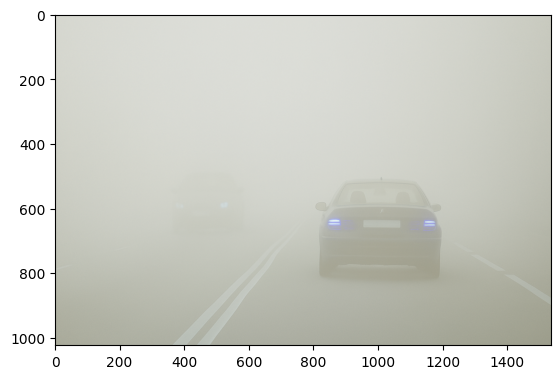

In [21]:
img_path = '/content/foggimage.png'
img = plt.imread(img_path)
result = Autonomus_vechiles(img)
plt.imshow(result)